- Check Shap Value 
- Check feature importance 
- Check Catboost 
- Check SVM 
- Decide the importance of False Positives and the False Negatives 
- Ver modelo de regressão com o outro target
- Colocar accuracy de todos os modelos numa mesma tabela

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score,precision_recall_curve,roc_curve,f1_score

In [113]:
df = pd.read_csv("../df_f_Switzerland.csv")

In [114]:
X_feature = ["Ground", "Prize", "GameRound", "Tornament_Days", "Rank_Diff"]
y_target = ["Num_Sets"]

In [115]:
df_ = df[X_feature + y_target]
df_

,Ground,Prize,GameRound,Tornament_Days,Rank_Diff,Num_Sets
0,Hard,1308100.0,Round of 16,6,63,2
1,Hard,1308100.0,Round of 32,6,46,3
2,Hard,1225000.0,Semi-Finals,6,29,2
3,Hard,1225000.0,Quarter-Finals,6,63,2
4,Hard,1225000.0,Round of 32,6,23,2
...,...,...,...,...,...,...
4922,Clay,15000.0,Round of 16,6,365,2
4923,Carpet,25000.0,Round of 32,6,684,3
4924,Clay,15000.0,Round of 32,6,583,3
4925,Clay,15000.0,Round of 32,6,384,2


# Train Test Split

In [116]:
df["Num_Sets"].value_counts()

Num_Sets
2    3243
3    1657
4      18
5       9
Name: count, dtype: int64

In [117]:
from sklearn.model_selection import train_test_split
train_set,data_set = train_test_split(df_,test_size=0.3,random_state=42, stratify=df_['Num_Sets'])
val_set, test_set = train_test_split(data_set,test_size=0.3,random_state=42, stratify=data_set['Num_Sets'])

In [118]:
X_train = train_set.drop("Num_Sets",axis=1)
y_train = train_set["Num_Sets"]

X_val = val_set.drop("Num_Sets",axis=1)
y_val = val_set["Num_Sets"]


X_test = test_set.drop("Num_Sets",axis=1)
y_test = test_set["Num_Sets"]

# Preprocessing

In [119]:
cat_attributes = ["Ground", "GameRound"]
num_attributes = ["Prize", "Tornament_Days", "Rank_Diff"]

In [120]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [121]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
num_pipeline = Pipeline([
        ('selector',DataFrameSelector(num_attributes)),
        ('std_scaler', StandardScaler()),
    ])

cat_pipeline = Pipeline([
        ('selector',DataFrameSelector(cat_attributes)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [122]:
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [123]:
X_train_prepared = full_pipeline.fit_transform(X_train)
X_val_prepared = full_pipeline.transform(X_val)

/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Trying Auto ML

In [124]:
Accuracy_train = []
Precision_train = []
Recall_train = []
Accuracy_val = []
Precision_val = []
Recall_val = []
Model = ["Logaritimic", "RandomForest", "XG-Boost", "Catboost", "SVM (Sigmoid)"]

# Training a Logistic Regression model

In [125]:
from sklearn.linear_model import LogisticRegressionCV

In [126]:
log_model = LogisticRegressionCV(solver='liblinear',cv=3)
log_model.fit(X_train_prepared, y_train)

LogisticRegressionCV(cv=3, solver='liblinear')

In [127]:
# O training data
predictions_train = log_model.predict(X_train_prepared)

#On val data
predictions_val = log_model.predict(X_val_prepared)

## Confusion Matrix

### On train data

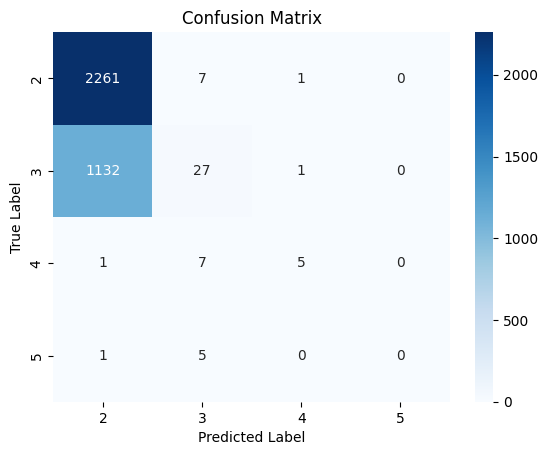

In [128]:
cm = confusion_matrix(y_train,predictions_train)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [129]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_train, predictions_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           2       0.67      1.00      0.80      2269
           3       0.59      0.02      0.04      1160
           4       0.71      0.38      0.50        13
           5       0.00      0.00      0.00         6

    accuracy                           0.67      3448
   macro avg       0.49      0.35      0.34      3448
weighted avg       0.64      0.67      0.54      3448



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

### On val data

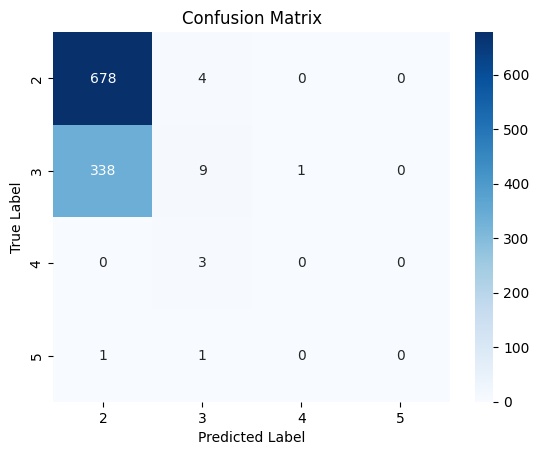

In [130]:
cm = confusion_matrix(y_val,predictions_val)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [131]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_val, predictions_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           2       0.67      0.99      0.80       682
           3       0.53      0.03      0.05       348
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2

    accuracy                           0.66      1035
   macro avg       0.30      0.25      0.21      1035
weighted avg       0.62      0.66      0.54      1035



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [132]:
Precision_train.append(precision_score(y_train, predictions_train, average='weighted'))
Accuracy_train.append(accuracy_score(y_train, predictions_train))
Recall_train.append(recall_score(y_train, predictions_train, average='weighted'))

Precision_val.append(precision_score(y_val, predictions_val, average='weighted'))
Accuracy_val.append(accuracy_score(y_val, predictions_val))
Recall_val.append(recall_score(y_val, predictions_val, average='weighted'))

/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Training a Random Forest

In [133]:
from sklearn.ensemble import RandomForestClassifier

In [134]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train_prepared,y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [135]:
predictions_train = rnd_clf.predict(X_train_prepared)
predictions_val = rnd_clf.predict(X_val_prepared)

### On training data

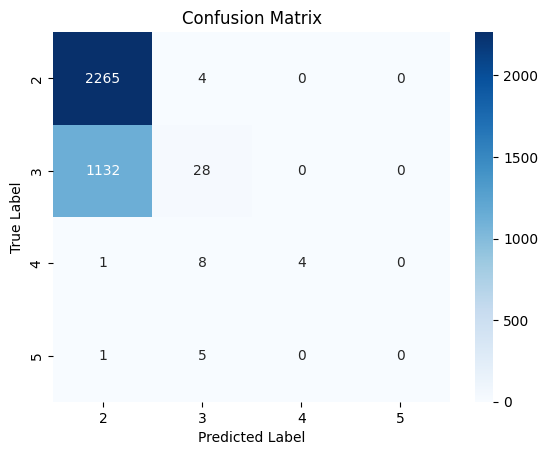

In [136]:
cm = confusion_matrix(y_train,predictions_train)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [137]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_train, predictions_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           2       0.67      1.00      0.80      2269
           3       0.62      0.02      0.05      1160
           4       1.00      0.31      0.47        13
           5       0.00      0.00      0.00         6

    accuracy                           0.67      3448
   macro avg       0.57      0.33      0.33      3448
weighted avg       0.65      0.67      0.54      3448



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

### Val data

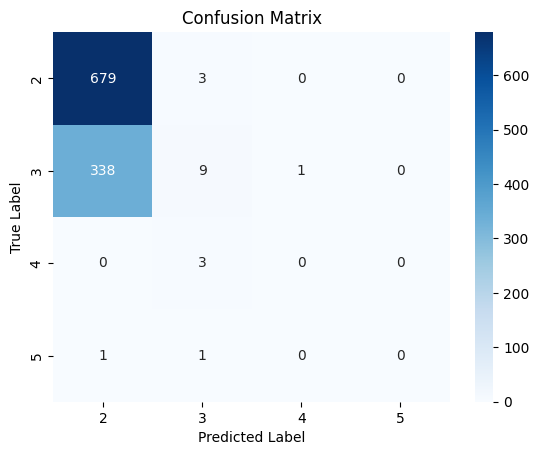

In [138]:
cm = confusion_matrix(y_val,predictions_val)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [139]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_val, predictions_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           2       0.67      1.00      0.80       682
           3       0.56      0.03      0.05       348
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2

    accuracy                           0.66      1035
   macro avg       0.31      0.26      0.21      1035
weighted avg       0.63      0.66      0.54      1035



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [140]:
Precision_train.append(precision_score(y_train, predictions_train, average='weighted'))
Accuracy_train.append(accuracy_score(y_train, predictions_train))
Recall_train.append(recall_score(y_train, predictions_train, average='weighted'))

Precision_val.append(precision_score(y_val, predictions_val, average='weighted'))
Accuracy_val.append(accuracy_score(y_val, predictions_val))
Recall_val.append(recall_score(y_val, predictions_val, average='weighted'))

/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# XG-Boost 

In [141]:
import xgboost as xgb

In [142]:
to_map = {2:0, 3:1, 4:2, 5:3}
Y_train = y_train.map(to_map)
Y_val = y_val.map(to_map)

In [143]:
model = xgb.XGBClassifier(objective="multi:softmax", num_class=4, random_state=42, max_depth=3, min_child_weight=1, gamma=0.05, subsample=0.8, colsample_bytree=0.8,n_estimators=75)

In [144]:
model.fit(X_train_prepared, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=75, n_jobs=None, num_class=4, num_parallel_tree=None,
              objective='multi:softmax', ...)

In [145]:
predictions_train = model.predict(X_train_prepared)
predictions_val = model.predict(X_val_prepared)

### Train set

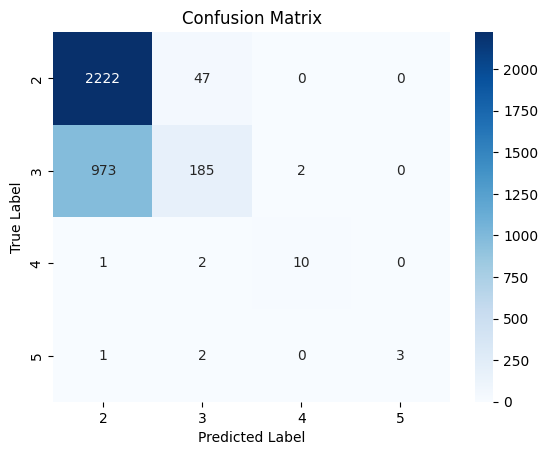

In [146]:
cm = confusion_matrix(Y_train,predictions_train)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [147]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_train, predictions_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.70      0.98      0.81      2269
           1       0.78      0.16      0.27      1160
           2       0.83      0.77      0.80        13
           3       1.00      0.50      0.67         6

    accuracy                           0.70      3448
   macro avg       0.83      0.60      0.64      3448
weighted avg       0.73      0.70      0.63      3448



### Val set

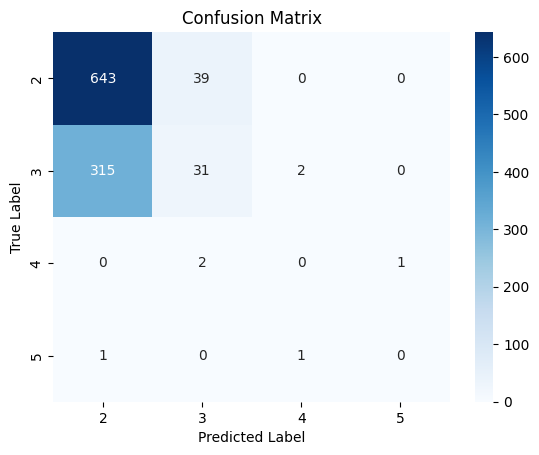

In [148]:
Y_val = y_val.map(to_map)
cm = confusion_matrix(Y_val,predictions_val)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [149]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, predictions_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.67      0.94      0.78       682
           1       0.43      0.09      0.15       348
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.65      1035
   macro avg       0.28      0.26      0.23      1035
weighted avg       0.59      0.65      0.57      1035



In [150]:
Precision_train.append(precision_score(Y_train, predictions_train, average='weighted'))
Accuracy_train.append(accuracy_score(Y_train, predictions_train))
Recall_train.append(recall_score(Y_train, predictions_train, average='weighted'))

Precision_val.append(precision_score(Y_val, predictions_val, average='weighted'))
Accuracy_val.append(accuracy_score(Y_val, predictions_val))
Recall_val.append(recall_score(Y_val, predictions_val, average='weighted'))

## Catboost

In [151]:
import catboost as cb

In [152]:
cat_features = [0,2]

In [153]:
from catboost import Pool
train_pool = Pool(
    data=X_train, 
    label=y_train, 
    cat_features=cat_features
)

validation_pool = Pool(
    data=X_val, 
    label=y_val, 
    cat_features=cat_features
)

test_pool = Pool(
    data=X_test, 
    label=y_test, 
    cat_features=cat_features
)

In [154]:
clf = cb.CatBoostClassifier(iterations=200, learning_rate=0.05, random_seed=42, loss_function='MultiClass', eval_metric='MultiClass')

In [155]:
clf.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=10, verbose=10, cat_features=[0,2])

0:	learn: 1.3283710	test: 1.3289562	best: 1.3289562 (0)	total: 8.23ms	remaining: 1.64s
10:	learn: 0.9927083	test: 0.9931525	best: 0.9931525 (10)	total: 29.8ms	remaining: 512ms
20:	learn: 0.8439004	test: 0.8446524	best: 0.8446524 (20)	total: 53.8ms	remaining: 459ms
30:	learn: 0.7658267	test: 0.7669580	best: 0.7669580 (30)	total: 72.9ms	remaining: 397ms
40:	learn: 0.7167095	test: 0.7198852	best: 0.7198852 (40)	total: 99.8ms	remaining: 387ms
50:	learn: 0.6881877	test: 0.6930676	best: 0.6930676 (50)	total: 127ms	remaining: 370ms
60:	learn: 0.6716902	test: 0.6788011	best: 0.6788011 (60)	total: 149ms	remaining: 341ms
70:	learn: 0.6601443	test: 0.6695576	best: 0.6695576 (70)	total: 181ms	remaining: 329ms
80:	learn: 0.6526745	test: 0.6643899	best: 0.6643899 (80)	total: 224ms	remaining: 329ms
90:	learn: 0.6482103	test: 0.6613357	best: 0.6613357 (90)	total: 263ms	remaining: 316ms
100:	learn: 0.6444984	test: 0.6591356	best: 0.6591356 (100)	total: 359ms	remaining: 352ms
110:	learn: 0.6417252	test:

In [156]:
# O training data
predictions_train = clf.predict(X_train)

#On val data
predictions_val = clf.predict(X_val)

### On training

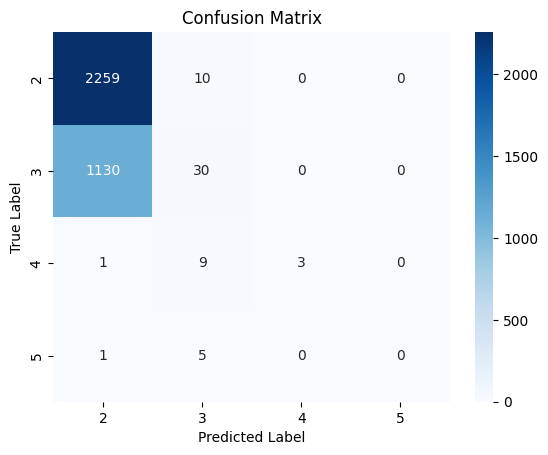

In [157]:
cm = confusion_matrix(y_train,predictions_train)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [158]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_train, predictions_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           2       0.67      1.00      0.80      2269
           3       0.56      0.03      0.05      1160
           4       1.00      0.23      0.38        13
           5       0.00      0.00      0.00         6

    accuracy                           0.66      3448
   macro avg       0.56      0.31      0.31      3448
weighted avg       0.63      0.66      0.54      3448



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

### On Validation

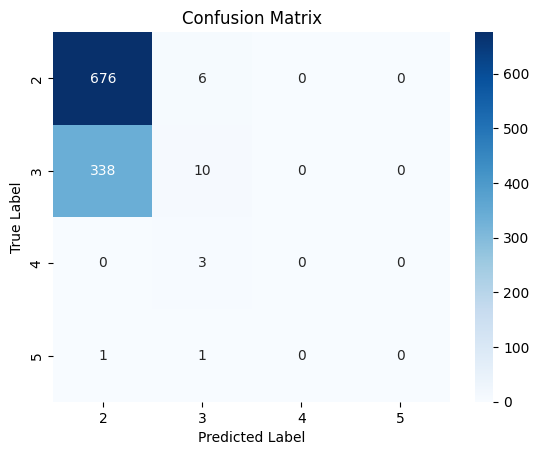

In [159]:
Y_val = y_val.map(to_map)
cm = confusion_matrix(y_val,predictions_val)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [160]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_val, predictions_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           2       0.67      0.99      0.80       682
           3       0.50      0.03      0.05       348
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2

    accuracy                           0.66      1035
   macro avg       0.29      0.25      0.21      1035
weighted avg       0.61      0.66      0.54      1035



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [161]:
Precision_train.append(precision_score(y_train, predictions_train, average='weighted'))
Accuracy_train.append(accuracy_score(y_train, predictions_train))
Recall_train.append(recall_score(y_train, predictions_train, average='weighted'))

Precision_val.append(precision_score(y_val, predictions_val, average='weighted'))
Accuracy_val.append(accuracy_score(y_val, predictions_val))
Recall_val.append(recall_score(y_val, predictions_val, average='weighted'))

/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## SVM model

In [162]:
from sklearn.svm import SVC

In [163]:
clf = SVC(kernel='sigmoid')

In [164]:
clf.fit(X_train_prepared, Y_train)

SVC(kernel='sigmoid')

In [165]:
# O training data
predictions_train = clf.predict(X_train_prepared)

#On val data
predictions_val = clf.predict(X_val_prepared)

### Train set

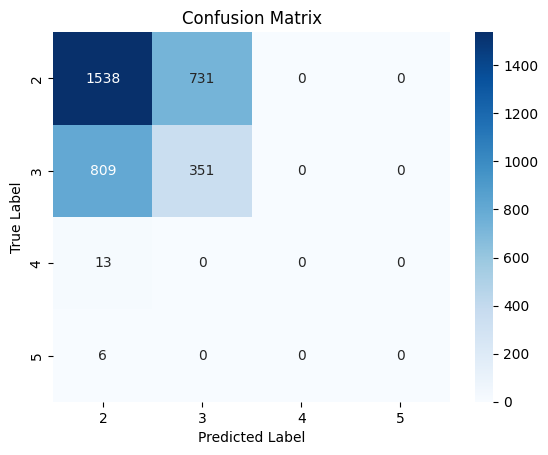

In [166]:
cm = confusion_matrix(Y_train,predictions_train)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [167]:
# Generate a classification report
report = classification_report(Y_train, predictions_train)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.65      0.68      0.66      2269
           1       0.32      0.30      0.31      1160
           2       0.00      0.00      0.00        13
           3       0.00      0.00      0.00         6

    accuracy                           0.55      3448
   macro avg       0.24      0.25      0.24      3448
weighted avg       0.54      0.55      0.54      3448



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

### Val Set

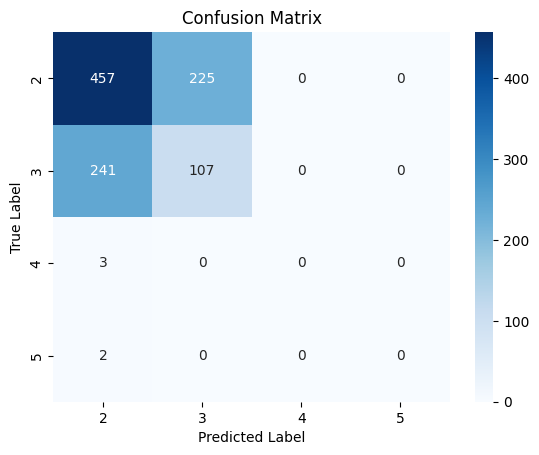

In [168]:
Y_val = y_val.map(to_map)
cm = confusion_matrix(Y_val,predictions_val)
y_train_labels = sorted(y_train.unique())
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=y_train_labels, yticklabels=y_train_labels)

# Set the plot title and axis labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the plot
plt.show()

In [169]:
from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(Y_val, predictions_val)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.65      0.67      0.66       682
           1       0.32      0.31      0.31       348
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         2

    accuracy                           0.54      1035
   macro avg       0.24      0.24      0.24      1035
weighted avg       0.54      0.54      0.54      1035



/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

In [170]:
Precision_train.append(precision_score(Y_train, predictions_train, average='weighted'))
Accuracy_train.append(accuracy_score(Y_train, predictions_train))
Recall_train.append(recall_score(Y_train, predictions_train, average='weighted'))

Precision_val.append(precision_score(Y_val, predictions_val, average='weighted'))
Accuracy_val.append(accuracy_score(Y_val, predictions_val))
Recall_val.append(recall_score(Y_val, predictions_val, average='weighted'))

/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/.local/share/virtualenvs/PACD1-1HdaorPT/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Final Df

In [172]:
dict_to_df = {"Accuracy_train": Accuracy_train, "Accuracy_val": Accuracy_val, "Precision_train": Precision_train, "Precision_val":Precision_val, "Recall_train": Recall_train, "Recall_val":Recall_val}
df_model = pd.DataFrame(index=Model, data=dict_to_df)
df_model

,Accuracy_train,Accuracy_val,Precision_train,Precision_val,Recall_train,Recall_val
Logaritimic,0.665023,0.663768,0.638417,0.617297,0.665023,0.663768
RandomForest,0.666183,0.664734,0.651617,0.628638,0.666183,0.664734
XG-Boost,0.701856,0.651208,0.725978,0.586577,0.701856,0.651208
Catboost,0.664733,0.662802,0.629059,0.606975,0.664733,0.662802
SVM (Sigmoid),0.547854,0.544928,0.536905,0.536720,0.547854,0.544928
